# Mutual Information between spiking and location

In [3]:
import numpy as np
from numpy.random import shuffle, default_rng
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import glob
import sys
from sklearn.mixture import GaussianMixture
from sklearn import linear_model
from scipy.interpolate import interp1d
from numpy.linalg import norm
from scipy.special import jv
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from helper_functions_hc3_preprocessing import * 

%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# This option supresses chained assignment warnings: Be careful with usig chanied assignments in this
pd.set_option('mode.chained_assignment', None)

## load the files for analysis

# set paths
DATA_PATH = '/home/vjaltare/Documents/datasets/hc3/processed_files/final_processed_files'
ch_dir(DATA_PATH)

# load files
loc_time_df = pd.read_csv('gor01_2006-6-7_11-26-53_loc_time.csv')
#print(loc_time_df.head())
spt_df = pd.read_csv('gor01_filtered_ca3_spiketimes.csv')
#print(spt_df.head())
spt_loc_df = pd.read_csv('gor01-ca3_spiketime-location.csv')
#print(spt_loc_df.head())
speed_df = get_speed_df(loc_time_df)
# print(speed_df.head())

# filter speed df by a few different thresholds
## 15th percentile of velocity is the threshold
filter_speed_15 = circularize_location(speed_df, 15, True)
## 50th percentile is the threshold
filter_speed_50 = circularize_location(speed_df, 50, True)
## 90the percentile is the threshold
filter_speed_90 = circularize_location(speed_df, 90, True)

print(filter_speed_15.head())


         vx        vy        x1        y1         t        xc
0  2.526010 -0.313261  0.937571  0.030530  0.025602  2.945466
1  2.576398 -0.254281  0.938426  0.030455  0.051203  2.948151
2  2.873254  0.090229  0.939379  0.030482  0.076805  2.951146
3  2.885753  0.354665  0.940336  0.030585  0.102407  2.954153
4  2.930672  1.258513  0.941308  0.030952  0.128008  2.957207


In [9]:
v_prc_15 = np.percentile(speed_df['vx'].abs(), 15)
print(f'15th percentile of velocity = {v_prc_15:.03f} cm/s')
v_prc_50 = np.percentile(speed_df['vx'].abs(), 50)
print(f'50th percentile of velocity = {v_prc_50:.03f} cm/s')
v_prc_90 = np.percentile(speed_df['vx'].abs(), 90)
print(f'90th percentile of velocity = {v_prc_90:.03f} cm/s')

15th percentile of velocity = 0.097 cm/s
50th percentile of velocity = 0.549 cm/s
90th percentile of velocity = 4.261 cm/s


# Finding $N(x)$

In [ ]:
## occupant probability p(x)

# use the histogram from loc_time_df
# One option to use as bins: np.int16(np.ceil(loc_time_df['x1'].max()))
Nx, binsx = np.histogram(loc_time_df['x1'], bins = 100)

# print(f'n: {n_x}, bins: {bins_x}')

# density = True gives a PDF

fig, ax = plt.subplots(dpi=80)
Nx, binsx, patchesx = ax.hist(loc_time_df['x1'], bins=100, alpha=0.5, density=True)
ax.set_xlabel(f'Position $x$ (cm)')
ax.set_ylabel(f'$N(x)$')

# binsize?
bin_size = np.diff(binsx)
print(f'bin size: {bin_size[0]} (cm)')

In [ ]:
## check if nx is a pdf
if np.sum(Nx*bin_size) == 1.0:
    print(f'sum(N(x)*bin_size) = {np.sum(Nx*bin_size)}')
    print('N(x) is a PDF')

# Finding $\lambda(x)$ and $\lambda$

- Consider any neuron on any electrode for now

In [ ]:
# determine neuron with most number of spikes on electrode 2
ele = 3

# no. of unique neuron clusters
elec_filtered = spt_loc_df.loc[spt_loc_df['electrode'] == ele]
unique_clu = np.array(elec_filtered['cluster'].unique())
unique_clu.sort()
print(f'unique clusters: {unique_clu}')


# def max_spike_cells(df):
#     # extract the unique clusters
#     unique_clu = np.array(df['cluster'].unique())
#     unique_clu.sort()

#     for i in unique_clu:
#         cdf = 1



In [ ]:
# plot histogram along the x_mean axis of spt_loc_df
ele = 2
clu = 14


sptx = spt_loc_df.loc[spt_loc_df['electrode'] == ele].loc[spt_loc_df['cluster'] == clu]
# print(sptx.head())
print(sptx.shape[0])


# total spikes
tot_spikes = sptx.shape[0]

# plot histogram
fig, ax = plt.subplots(dpi=80)
n_lambdax, bins_lambdax, patches_lambdax = ax.hist(sptx['x_mean'], bins=100, alpha=0.5, label = 'No time shift')
n_lambdax, bins_lambdax, patches_lambdax = ax.hist(sptx['x_mean'].loc[(sptx['x_mean'] > 20) & (sptx['x_mean'] <=70)], bins=100, alpha=0.5, label = 'No time shift')
ax.set_xlabel(f'$x$ (cm)')
ax.set_ylabel(f'$\lambda(x)$')


$$\lambda = \int_x \lambda(x)p(x)dx$$

In [ ]:
# plot histogram along the x_mean axis of spt_loc_df
ele = 2
clu = 3


sptx = spt_loc_df.loc[spt_loc_df['electrode'] == ele].loc[spt_loc_df['cluster'] == clu]

# sampling frequency of location
fsx = 39.06 #Hz
# overall firing rate
n_lambdax, bins_lambdax = np.histogram(sptx['x_mean'], bins=100,density=True)
n_lambdax = n_lambdax*fsx
n_x, bins_x = np.histogram(loc_time_df['x1'], bins=100, density=True)

def exp_value(lx, px, bins):
    ''''Function gives expectation value given lambda(x) and p(x) = lambda'''
    # bin size 
    bin_size = np.diff(bins)[0]

    # dot product of the arrays* bin size == discrete integral
    l = np.dot(lx,px)*bin_size

    return l


In [ ]:
l = exp_value(n_lambdax, n_x, bins_lambdax)

print(f'lambda = {l} Hz')

In [ ]:
# Pilot run for finding information

def mi(lx, px, bin_loc):
    '''function to output mutual information'''
    bin_size = np.diff(bin_loc)[0] # assuming equispaced bins
    # remove the zeros in lambda(x) so that the log doesn't blow
    ## make a dummy dataframe
    dummy = pd.DataFrame(
        {
            'lx': lx,
            'px': px
        }
    )
    ## remove the rows with lx=0
    dummy = dummy.loc[dummy['lx'] > 0]
    l_overall = exp_value(dummy['lx'], dummy['px'], bin_loc)
    l_log = np.multiply(dummy['lx'], np.log2(dummy['lx']/l_overall))
    mi = np.dot(l_log, dummy['px'])

    return mi



In [ ]:
I = mi(n_lambdax, n_x, bins_lambdax)
print(f'Mutual information = {I} (bits/s)')


# For Thursday: Write a script to infer location for time-shifted spiking activity

In [ ]:
## script to infer location for time-shifted neural activity

# write a function that takes in a time delay in seconds and 
# outputs a dataframe that has columns electrode, cell, x_mean, y_mean

def delay_spiketrain(t_shift, ele, cell):
    '''a function that takes in a time delay in seconds, electrode and cell 
    outputs a dataframe that has columns electrode, cell, x_mean, y_mean
    USE t_shift WITH SIGN: - means time advance, + means time delay'''

    # Load the x-y-t dataframe
    xyt_df = pd.read_csv('gor01_2006-6-7_11-26-53_loc_time.csv')
    # Load the ele-clu-spt file
    cell_spt_df = pd.read_csv('gor01_filtered_ca3_spiketimes.csv')
    # sort the spt file by spiketimes
    cell_spt_df.sort_values(by=['spiketime'], inplace=True)
    cell_spt_df.reset_index(drop=True, inplace=True)
    # consider only a given electrode and cluster
    cell_spt_df = cell_spt_df.loc[cell_spt_df['electrode'] == ele].loc[cell_spt_df['cluster'] == cell]

    # time bins: 1/39.06 s
    t_arr = xyt_df['t'].to_numpy()
    # shift the spiketime array
    cell_spt_df['spiketime'] = cell_spt_df['spiketime'] + t_shift
    # drop negative spiketimes
    cell_spt_df = cell_spt_df.loc[cell_spt_df['spiketime'] > 0]
    # extract spiketimes onto a numpy array
    spt = cell_spt_df['spiketime'].to_numpy()

    for i in range(t_arr.shape[0]-1):
        idx = np.where((spt >= t_arr[i]) & (spt < t_arr[i+1]))[0]
        #print(idx)
        if idx.shape[0] > 0:
            # avg x-location
            avg_locx = xyt_df.iloc[i:i+1, 0].to_numpy()
            #print(avg_locx)
            avg_locx = np.mean(avg_locx)
            # loc_listx.append(avg_locx)
            # avg y location
            avg_locy = xyt_df.iloc[i:i+1, 1].to_numpy()
            avg_locy = np.mean(avg_locy)
            # loc_listy.append(avg_locy)

            # add the locations to the spiketime file at appropriate indices
            cell_spt_df.loc[idx[0]:idx[-1], 'x_mean'] = avg_locx
            cell_spt_df.loc[idx[0]:idx[-1], 'y_mean'] = avg_locy
        
    print(cell_spt_df.head())

    return cell_spt_df



In [ ]:
aa = delay_spiketrain(-100e-3,2,14)
type(aa)

# Putting all the functions in a place

In [ ]:
## Putting all the functions at a single place

def delay_spiketrain(t_shift, ele, cell):
    '''a function that takes in a time delay in seconds, electrode and cell 
    outputs a dataframe that has columns electrode, cell, x_mean, y_mean
    USE t_shift WITH SIGN: - means time advance, + means time delay'''
    # Make sure we're in the right directory
    ch_dir(DATA_PATH)

    # Load the x-y-t dataframe
    xyt_df = pd.read_csv('gor01_2006-6-7_11-26-53_loc_time.csv')
    # Load the ele-clu-spiketime file
    cell_spt_df = pd.read_csv('gor01_filtered_ca3_spiketimes.csv')
    # consider only a given electrode and cluster
    cell_spt_df = cell_spt_df.loc[cell_spt_df['electrode'] == ele].loc[cell_spt_df['cluster'] == cell]
    # sort the spt file by spiketimes
    cell_spt_df.sort_values(by=['spiketime'], inplace=True)
    cell_spt_df.reset_index(drop=True, inplace=True)
    # time bins: 1/39.06 s
    t_arr = xyt_df['t'].to_numpy()
    # shift the spiketime array
    cell_spt_df['spiketime'] = cell_spt_df['spiketime'] + t_shift
    # drop negative spiketimes
    cell_spt_df = cell_spt_df.loc[cell_spt_df['spiketime'] > 0]
    # extract spiketimes onto a numpy array
    spt = cell_spt_df['spiketime'].to_numpy()

    for i in range(t_arr.shape[0]-1):
        idx = np.where((spt >= t_arr[i]) & (spt < t_arr[i+1]))[0]
        #print(idx)
        if idx.shape[0] > 0:
            # avg x-location
            avg_locx = xyt_df.iloc[i:i+1, 0].to_numpy()
            #print(avg_locx)
            avg_locx = np.mean(avg_locx)
            # loc_listx.append(avg_locx)
            # avg y location
            avg_locy = xyt_df.iloc[i:i+1, 1].to_numpy()
            avg_locy = np.mean(avg_locy)
            # loc_listy.append(avg_locy)

            # add the locations to the spiketime file at appropriate indices
            cell_spt_df.loc[idx[0]:idx[-1], 'x_mean'] = avg_locx
            cell_spt_df.loc[idx[0]:idx[-1], 'y_mean'] = avg_locy
        
    print(cell_spt_df.head())

    return cell_spt_df


def mi(lx, px, bin_loc):
    '''function to output mutual information'''
    bin_size = np.diff(bin_loc)[0] # assuming equispaced bins
    # remove the zeros in lambda(x) so that the log doesn't blow
    ## make a dummy dataframe
    dummy = pd.DataFrame(
        {
            'lx': lx,
            'px': px
        }
    )
    ## remove the rows with lx=0
    dummy = dummy.loc[dummy['lx'] > 0]
    # find overall firing rate 
    l_overall = exp_value(dummy['lx'], dummy['px'], bin_loc)
    # split up the sum into two parts
    l_log = np.multiply(dummy['lx'], dummy['px'])
    mi = np.dot(l_log, np.log2(dummy['lx']/l_overall))

    return mi

def mi_spike(lx, px, bin_loc):
    '''function to output mutual information'''
    bin_size = np.diff(bin_loc)[0] # assuming equispaced bins
    # remove the zeros in lambda(x) so that the log doesn't blow
    ## make a dummy dataframe
    dummy = pd.DataFrame(
        {
            'lx': lx,
            'px': px
        }
    )
    ## remove the rows with lx=0
    dummy = dummy.loc[dummy['lx'] > 0]
    # find overall firing rate 
    l_overall = exp_value(dummy['lx'], dummy['px'], bin_loc)
    # split up the sum into two parts
    l_log = np.multiply(dummy['lx'], dummy['px'])
    mi = np.dot(l_log, np.log2(dummy['lx']/l_overall))

    return mi/l_overall

def exp_value(lx, px, bins):
    ''''Function gives expectation value given lambda(x) and p(x) = lambda'''
    # bin size 
    bin_size = np.diff(bins)[0]

    # dot product of the arrays* bin size == discrete integral
    l = np.dot(lx,px)*bin_size

    return l



In [ ]:
# comparing the time-shifted distributions with no time shift data
t1 = 0#-1000e-3
t2 = -100e-3
spt100_lead = delay_spiketrain(t1, 2, 14)
spt100_lag = delay_spiketrain(t2, 2, 14)



## Plotting
fig, ax = plt.subplots(dpi=150)
Nx, binsx, patchesx = ax.hist(loc_time_df['x1'], bins=100, alpha=0.5, density=True, label=r'$N(x)$')
lx100_lead, bins_lx100_lead, patches100_lead = ax.hist(spt100_lead['x_mean'], bins=100, alpha=0.5, density=True, label=f'$\lambda(x) \quad \Delta t = {-t1:.01f} s$')
lx100_lag, bins_lx100_lag, patches100_lag = ax.hist(spt100_lag['x_mean'], bins=100, alpha=0.5, density=True, label=f'$\lambda(x) \quad \Delta t = {-t2:.01f} s$')
ax.set_xlabel(f'Position $x$ (cm)')
ax.set_ylabel(f'Probability')
ax.legend(frameon=False)
sns.despine()

In [ ]:
## Pilot run for ele = 2, clu = 14

# array of delay times in seconds
tshift_arr = np.arange(-300, 120, 20)*1e-3

# define cell and electrode
ele = 2
clu = 10

# p(x) doesn't change
Nx, binsx = np.histogram(loc_time_df['x1'], bins=150, density=True)

# create a datagrame to dump the t, MI values
mi_df = pd.DataFrame(columns=['electrode', 'cell', 't_shift', 'I'])

# empty lists
mi_list = []
tshift_list = []


# iterate over time delays
for i,t in enumerate(tshift_arr):
    # find the l(x) for each time delay
    df = delay_spiketrain(t,ele,clu)
    df.dropna(inplace=True)
    lx, bx = np.histogram(df['x_mean'], bins=150, density=True)
    # get rate from no. of spikes
    lx = lx*fsx

    # find mutual information between spiketrain and location
    MI = mi(lx, Nx, bx)

    # dump the MI and time delay onto a list
    mi_list.append(MI)
    tshift_list.append(t)



print(f'MI: {mi_list}, t:{tshift_list}')


    


In [ ]:
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=100)
ax.plot(tshift_list, mi_list, marker='o', lw=0.5)
ax.set_xlabel(f'Time shift (s)')
ax.set_ylabel(f'Information rate (bits/s)')
ax.set_title(f'cell: {clu}, ele: {ele}')

# ax[1].hist()

In [ ]:
# t = -100e-3
# ele = 2
# clu = 14
# df = delay_spiketrain(t,ele,clu)

np.diff(bx)

In [ ]:
## RUN THIS CELL: To get a file with MI

ch_dir(DATA_PATH)
## Extending to all the cells in an electrode
spt_loc_df = pd.read_csv('gor01-ca3_spiketime-location.csv')
# find the cells for a given electrode
ele = 2
# no. of unique neuron clusters
elec_filtered = spt_loc_df.loc[spt_loc_df['electrode'] == ele]
unique_clu = np.array(elec_filtered['cluster'].unique())
unique_clu.sort()

# array of delay times in seconds
tshift_arr = np.arange(-1000, 0, 100)*1e-3

# define cell and electrode


# p(x) doesn't change
Nx, binsx = np.histogram(loc_time_df['x1'], bins=150, density=True)

# create a datagrame to dump the t, MI values
mi_df = pd.DataFrame(columns=['electrode', 'cell', 't_shift', 'I'])

# empty lists
mi_list = []
tshift_list = []

for clu in unique_clu:
    # empty lists
    mi_list = []
    tshift_list = []
# iterate over time delays
    for i,t in enumerate(tshift_arr):
        # find the l(x) for each time delay
        df = delay_spiketrain(t,ele,clu)
        df.dropna(inplace=True)
        lx, bx = np.histogram(df['x_mean'], bins=150, density=True)
        # get rate from no. of spikes
        lx = lx*fsx

        # find mutual information between spiketrain and location
        MI = mi(lx, Nx, bx)

    # dump the MI and time delay onto a list
        mi_list.append(MI)
        tshift_list.append(t)

    dummy = pd.DataFrame(
        {
            'electrode': np.ones(len(mi_list))*ele,
            'cell': np.ones(len(mi_list))*clu,
            't_shift': np.array(tshift_list),
            'I': np.array(mi_list)
        }
    )

    # mi_df = pd.concat([mi_df, dummy], axis=0, names=['electrode', 'cell', 't_shift', 'I'], ignore_index=True)
    # mi_df.to_csv(f'/home/vjaltare/Documents/datasets/hc3/mi_data_files/mi_ele{ele}.csv', index=False, mode='a+')
    if clu == unique_clu[0]:
        idx_flag = True
    else:
        idx_flag = False
    dummy.to_csv(f'/home/vjaltare/Documents/datasets/hc3/mi_data_files/mi_ele{ele}.csv', index=False, mode='a+', header=idx_flag)






print(f'MI: {mi_list}, t:{tshift_list}')

In [ ]:
# plot all the cells in a given electrode:
sns.set_palette('deep')
mi_data_PATH = '/home/vjaltare/Documents/datasets/hc3/mi_data_files/'
ch_dir(mi_data_PATH)
# load the file
ele = 2
filename = f'mi_ele{ele}.csv'
mi_file = pd.read_csv(mi_data_PATH + filename)
mi_file.head()

fig, ax = plt.subplots(dpi = 150)
cell_list = mi_file['cell'].unique()
# elec_filtered = spt_loc_df.loc[spt_loc_df['electrode'] == ele]
# unique_clu = np.array(elec_filtered['cluster'].unique())
# unique_clu.sort()
for i,c in enumerate(cell_list[-10:]):
    df = mi_file.loc[mi_file['cell'] == int(c)]
    ax.plot(-1e3*df['t_shift'], df['I'], lw=2, marker='o', label=f'neuron: {c:.0f}')
    ax.legend(frameon=False, loc=(1.0,0.07))

ax.set_xlabel(f'$\Delta t$ (ms)', size=14)
ax.set_ylabel(f'$I$ (bits/s)', size = 14)
sns.despine()

In [ ]:
cell_list

In [ ]:
## TESTING...
# Load the x-y-t dataframe
ele, cell, t_shift = [2,14,100e-3]

xyt_df = pd.read_csv('gor01_2006-6-7_11-26-53_loc_time.csv')
print(xyt_df.head())
# Load the ele-clu-spt file
cell_spt_df = pd.read_csv('gor01_filtered_ca3_spiketimes.csv')
# sort by spiketimes
cell_spt_df.sort_values(by=['spiketime'], inplace=True)
cell_spt_df.reset_index(drop=True, inplace=True)
# consider only a given electrode and cluster
cell_spt_df = cell_spt_df.loc[cell_spt_df['electrode'] == ele].loc[cell_spt_df['cluster'] == cell]
#print(f'cell_spt.head() \n {cell_spt_df.head()}')
# time bins: 1/39.06 s
# shift the time array
xyt_df['t'] = xyt_df['t'] + t_shift

cell_spt_df.reset_index(drop=True, inplace=True)
t_arr = xyt_df['t'].to_numpy()
#print(t_arr)

# extract spiketimes onto a numpy array
spt = cell_spt_df['spiketime'].to_numpy()

for i in range(t_arr.shape[0] - 1):
    # index of elements 
    idx = np.where((spt >= t_arr[i]) & (spt < t_arr[i+1]))[0]
    #print(idx)
    if idx.shape[0] > 0:
        # avg x-location
        avg_locx = xyt_df.iloc[i:i+1, 0].to_numpy()
        print(avg_locx)
        avg_locx = np.mean(avg_locx)
        #print(avg_locx)
        # loc_listx.append(avg_locx)
        # avg y location
        avg_locy = xyt_df.iloc[i:i+1, 1].to_numpy()
        avg_locy = np.mean(avg_locy)
        # loc_listy.append(avg_locy)

        # add the locations to the spiketime file at appropriate indices
        cell_spt_df.loc[idx[0]:idx[-1], 'x_mean'] = avg_locx
        cell_spt_df.loc[idx[0]:idx[-1], 'y_mean'] = avg_locy



cell_spt_df.dropna(inplace=True)
cell_spt_df.head()



In [ ]:
i, j = 0,1
print(t_arr[i], t_arr[j])
print(np.where((spt >= t_arr[i]) & (spt < t_arr[i+1]))[0])
print(np.where((spt <= t_arr[i+1]))[0])


In [ ]:
print(np.mean(xyt_df.iloc[5:6, 0]))
print(np.mean(xyt_df.iloc[0:1,0]))

In [ ]:
a1 = np.ones(10)*2
print(a1)
a2 = np.arange(10)
print(a2)
print(f'a1 times a2: {np.multiply(a1, a2)}')
a3 = np.multiply(a1, a2)
print(f'a1 times a2 dot a1/2: {np.dot(a3, a1/2)}')

# Fitting $p(x)$ and $\lambda(x)$ with von Mises functions

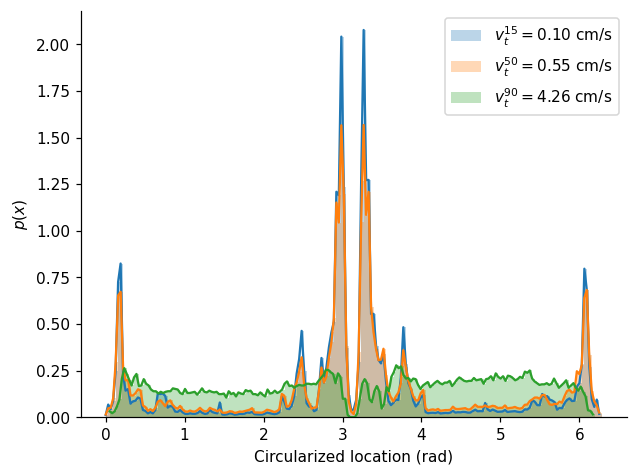

In [16]:
# plot histograms for speed-filtered locations
fig, ax = plt.subplots(dpi=110)
n_15, bins_15, patches_15 = ax.hist(filter_speed_15['xc'], bins=200, alpha=.3, label=f'$v_t^{{15}} = {v_prc_15 :.02f}$ cm/s', density=True)
n_50, bins_50, patches_50 = ax.hist(filter_speed_50['xc'], bins=200, alpha=.3, label=f'$v_t^{{50}} = {v_prc_50 :.02f}$ cm/s', density=True)
n_90, bins_90, patches_90 = ax.hist(filter_speed_90['xc'], bins=200, alpha=.3, label=f'$v_t^{{90}} = {v_prc_90 :.02f}$ cm/s', density=True)
ax.plot(bins_15[:-1], n_15, color='C0')
ax.plot(bins_50[:-1], n_50, color='C1')
ax.plot(bins_90[:-1], n_90, color='C2')
#ax.set_title(f'$p(x)$')
ax.set_xlabel(f'Circularized location (rad)')
ax.set_ylabel(f'$p(x)$')
ax.legend()
sns.despine()

#plt.savefig('/nadata/cnl/home/vjaltare/Documents/figures/hc3_analysis/speed_filtered_location_data-10-6.pdf', bbox_inches='tight')

In [ ]:
# Use pseudo-inverse to see a fit
n_15, bins_15 = np.histogram(filter_speed_15['xc'], bins=200, density=True)

X_15, theta_0_15 = span_x_von_Mises(30, n_15.shape[0])
# X_15 = X_15/np.amax(X_15[:,0])

# find coefficients by pseudo inverse
A_15 = pseudo_inverse_coefficients(X_15, n_15)
y_15_fit = X_15@A_15


In [ ]:
# plot the fitted function
fig, ax = plt.subplots(3,1,dpi=110, sharex=True)
ax[0].plot(bins_15[:-1], n_15, label='Data')
ax[0].plot(bins_15[:-1], y_15_fit, label='Pseudo-inverse fit')
ax[0].set_title(f'Linear Regression')
ax[0].set_xlabel(f'Circularized location (rad)')
ax[0].set_ylabel(f'$p(x)$')
ax[0].legend(frameon=False)

# plot coefficientsFittin
ax[1].plot(theta_0_15, A_15, lw=0.3, marker='o', alpha=.7)
ax[1].set_xlabel('Circularized Location (rad)')
ax[1].set_ylabel('Weights')

# # plot the von Mises functions tiling the track
ax[2].plot(bins_15[:-1], X_15, alpha=.7, lw=2.4)

fig.tight_layout()
sns.despine()

# plt.savefig('/nadata/cnl/home/vjaltare/Documents/figures/hc3_analysis/occupancy_lin_reg_th_15-10-17.pdf', bbox_inches='tight', transparent=True)

# Pseudo-inverse: Comments

1. The pseudo-inverse fits/smoothes the $p(x)$ reasonably well.
1. One possible good combination is 30 functions with $\kappa = 10$.
    1. for this case, the coefficients stayed between $-0.02$ to $0.02$.

1. Even-number of functions are good.

In [ ]:
# Write a function to perform RidgeCV

def ridge_cv(X, y, alpha):
    '''Performs ridge regression with cross-validation using scikit learn RidgeCV
    Input: 1. X: matrix whose columns are the von Mises functions tiling the track
           2. y: probability/frequency infered from histograms of the data
           3. alpha: vector of alpha parameters
    Output: 1. coefficients
            2. alphas
    '''
    reg = linear_model.RidgeCV(alphas=alpha)
    return reg.fit(X,y)



In [ ]:
# using ridge regression to fit p(x)
n_15, bins_15 = np.histogram(filter_speed_15['xc'], bins=200, density=True)
n_15_norm = n_15/np.trapz(n_15, bins_15[:-1])
X_15, theta_0_15 = span_x_von_Mises(17, n_15.shape[0])
# X_15 = X_15/np.amax(X_15[:,0])
alphas = np.logspace(-3, 100, 20)
fit = ridge_cv(X_15, n_15_norm, alphas)
A_15_ridge = fit.coef_

# find the fitted p(x)
n_ridge_15 = X_15@A_15_ridge 

# convert n_ridge to PDF
n_ridge_15 = n_ridge_15/np.trapz(n_ridge_15, bins_15[:-1])


In [ ]:
## plotting ridge regression results

# plot the fitted function
fig, ax = plt.subplots(3,1,dpi=110, sharex=True)
ax[0].plot(bins_15[:-1], n_15_norm, label='Data')
ax[0].plot(bins_15[:-1], n_ridge_15-np.amin(n_ridge_15), label='Ridge fit')
# ax[0].plot(bins_15[:-1], n_ridge_15, label='Ridge fit')
ax[0].set_title(f'RidgeCV')
ax[0].set_ylabel(f'$p(x)$')
ax[0].legend(frameon=False)
ax[0].text(5.3, 2.2, r'$\alpha =$' f'{fit.alpha_:.01e}')

# plot coefficients
ax[1].plot(theta_0_15, A_15_ridge, lw=0.3, marker='o', alpha=.7)
ax[1].set_ylabel('Weignts')

#plot basis functions
ax[2].plot(bins_15[:-1], X_15, lw=2.6, alpha=.7)
ax[2].set_xlabel('Circularized location (rad)')
ax[2].set_ylabel('Amplitude')

fig.tight_layout()
sns.despine()

plt.savefig('/nadata/cnl/home/vjaltare/Documents/figures/hc3_analysis/occupancy_ridge_reg_th_15-10-17.pdf', bbox_inches='tight', transparent=True)

In [ ]:
n_90, bins_90 = np.histogram(filter_speed_90['xc'], bins=300, density=True)

X_90, theta_0_90 = span_x_von_Mises(29, n_90.shape[0])
X_90 = X_90/np.amax(X_90[:,0])

# find coefficients by ridge CV
alphas = np.logspace(-3, 6, 10)
fit = ridge_cv(X_90, n_90, alphas)
A_ridge_90 = fit.coef_

# Construct the function
n_90_ridge = X_90@A_ridge_90
n_90_ridge = n_90_ridge/np.trapz(n_90_ridge, bins_90[:-1])

# plot the fitted function
fig, ax = plt.subplots(3,1,dpi=110, sharex=True)
ax[0].plot(bins_90[:-1], n_90, label='Data')
ax[0].plot(bins_90[:-1], n_90_ridge, label='RidgeCV fit')
#ax[0].set_title(f'$p(x)$')
# ax[0].set_xlabel(f'Circularized location (rad)')

ax[0].set_ylabel(f'$p(x)$')
ax[0].legend(loc=(1,.8), frameon=False)
ax[0].text(7,.4, r'$\alpha =$' f'${fit.alpha_:.01e}$')

# plot coefficients
ax[1].plot(theta_0_90, A_ridge_90, lw=0.3, marker='o', alpha=.7)
ax[1].set_ylabel('Weights')

#plot basis functions
ax[2].plot(bins_90[:-1], X_90, lw=2.6, alpha=.7)
ax[2].set_xlabel('Circularized Location (rad)')

fig.tight_layout()
sns.despine()

# plt.savefig('/nadata/cnl/home/vjaltare/Documents/figures/hc3_analysis/occupancy_ridge_reg_th_90-10-17.pdf', bbox_inches='tight', transparent=True)

# Working combinations for threshold speed = 90th percentile

- $\kappa = 100$, # functions = 29, normalize the von Mises functions

In [ ]:
# fitting vth = 90 with pseudo-inverse
n_90_pi, bins_90_pi = np.histogram(filter_speed_90['xc'], bins=200, density=True)

X_90_pi, theta_0_90_pi = span_x_von_Mises(30, n_90_pi.shape[0])
# X_90_pi = X_90_pi/np.amax(X_90_pi)

# find coefficients by pseudo inverse
A_90_pi = pseudo_inverse_coefficients(X_90_pi, n_90_pi)
y_90_pi_fit = X_90_pi@A_90_pi

# plot the fitted function
fig, ax = plt.subplots(3,1,dpi=110, sharex=True)
ax[0].plot(bins_90_pi[:-1], n_90_pi, label='Data')
ax[0].plot(bins_90_pi[:-1], y_90_pi_fit, label='Linear regression fit')
ax[0].set_title(f'$p(x)$')
ax[0].set_xlabel(f'Circularized location (rad)')

ax[0].set_ylabel(f'$p(x)$')
ax[0].legend(loc=(1,.8))

# plot coefficients
ax[1].plot(theta_0_90_pi, A_90_pi, lw=0.3, marker='o', alpha=.7)
ax[2].set_xlabel('Circularized Location (rad)')
ax[1].set_ylabel('Weights')

#plot basis functions
ax[2].plot(bins_90_pi[:-1], X_90_pi, lw=2.6, alpha=.7)

fig.tight_layout()
sns.despine()

# plt.savefig('/nadata/cnl/home/vjaltare/Documents/figures/hc3_analysis/occupancy_lin_reg_th_90-10-17.pdf', bbox_inches='tight', transparent=True)

# RidgeCV observations
1. It is in general very difficult to fit any of the functions with RidgeCV regression.
1. The $\kappa$ parameter has to be kept small for smoother fits. 
1. Larger values of $\kappa$ usually give a distribution with lot of negative values.
1. The number of functions can be kept $\leq 100$.
1. $\alpha$ is usually very small.

1. Odd-number of questions are good for 15th percentile plots.


# Interpolate the the $p(x)$
1. One option going forward might be trying to interpolate the $p(x)$ distribution.
1. Search for smoothning during interpolation.


# Determining $\lambda(x)$
1. Change the `delay_spiketime` function to read the circularized location file.
1. Get the discrete distribution for a given cell.
1. Fit (or rather try to) to von Mises functions.

# Funtion construction
- Write a function that takes in delay time, cell and electrode number and spits out discrete $\lambda(x)$ (Hz).

# Problems with `delay_spiketrain_circularized_loc`
- The function adds mean of successive location for every time bin spanning spiketime.
- This may be problematic when the velocity of the rat changes midway. The mean would just return $\pi$.
- To tackle this issue I'm doing the following:
    - inside the `if` block in the function consider the following conditions.
        1. if avg_locx[0] & avg_locx[1] <= $\pi$: avg_locx = mean(avg_locx)
        1. if avg_locx[0] & avg_locx[1] > $\pi$: avg_locx = mean(avg_locx)
        1. else: avg_locx = avg_locx[-1]
    - Assign the latest location as mean location, because the 'instantaneous velocity' will be in its direction.




In [ ]:
# def delay_spiketrain_speed(t_shift, ele, cell):
#     '''
#     This function takes time delay (signed in seconds), electrode #, cell # as inputs.
#     Output: Dataframe with columns electrode, cluster, x_mean, vx_mean.
#     The column x_mean can be used to get histogram for firing locations of the cell. 
#     vx_mean can be used to filter the output of this dataframe to the desired speed threshold
#     '''
#     # Make sure we're in the right directory
#     ch_dir(FIL_DATA_PATH)

#     # Load the x-y-t dataframe
#     xyt_df = pd.read_csv('gor01_2006-6-7_11-26-53_loc_time.csv')

#     # compute speed dataframe
#     speed_df = get_speed_df(xyt_df)

#     # circularize with NO threshold
#     circ_loc_df = circularize_location(speed_df, 0)

#     # Load the ele-clu-spiketime file
#     cell_spt_df = pd.read_csv('gor01_filtered_ca3_spiketimes.csv')

#     # consider only a given electrode and cluster
#     cell_spt_df = cell_spt_df.loc[cell_spt_df['electrode'] == ele].loc[cell_spt_df['cluster'] == cell]
#     # sort the spt file by spiketimes

#     cell_spt_df.sort_values(by=['spiketime'], inplace=True)
#     cell_spt_df.reset_index(drop=True, inplace=True)

#     # time bins: 1/39.06 s
#     t_arr = circ_loc_df['t'].to_numpy()

#     # shift the spiketime array
#     cell_spt_df['spiketime'] = cell_spt_df['spiketime'] + t_shift

#     # drop negative spiketimes
#     cell_spt_df = cell_spt_df.loc[cell_spt_df['spiketime'] > 0]

#     # extract spiketimes onto a numpy array
#     spt = cell_spt_df['spiketime'].to_numpy()

#     for i in range(t_arr.shape[0]-1):
#         idx = np.where((spt >= t_arr[i]) & (spt < t_arr[i+1]))[0]
#         #print(idx)
#         if idx.shape[0] > 0:
#             # avg x-location
#             avg_locx = circ_loc_df.iloc[i:i+2, -1].to_numpy()
#             # avg x-velocity
#             avg_vx = circ_loc_df.iloc[i:i+2, 0].to_numpy()
#             #print(avg_locx)

#             # select the appropriate mean location and append the mean x-velocity
#             if (avg_locx[0] <= np.pi) & (avg_locx[1] <= np.pi):
#                 avg_locx = np.mean(avg_locx)
#             elif (avg_locx[0] > np.pi) & (avg_locx[1] > np.pi):
#                 avg_locx = np.mean(avg_locx)
#             else:
#                 avg_locx = avg_locx[-1]

#             # select appropriate mean velocity
#             if (avg_vx[0] <= 0) & (avg_vx[1] <= 0):
#                 avg_vx = np.mean(avg_vx)
#             elif (avg_vx[0] > 0) & (avg_vx[1] > 0):
#                 avg_vx = np.mean(avg_vx)
#             else:
#                 avg_vx = avg_vx[-1]

#             # add the locations to the spiketime file at appropriate indices
#             cell_spt_df.loc[idx[0]:idx[-1]+1, 'x_mean'] = avg_locx
#             cell_spt_df.loc[idx[0]:idx[-1]+1, 'vx_mean'] = avg_vx
#             # cell_spt_df.loc[idx[0]:idx[-1], 'y_mean'] = avg_locy
        
#     cell_spt_df.dropna(inplace=True)

#     return cell_spt_df

# def filter_spiketimes_by_speed(cell_spt_df, v_threshold, prc_flag):
#     '''
#     This function takes in the output of the delay_spiketrain_speed function and returns the speed_filtered version of it.
#     1. if v_threshold is a percentile, set the prc_flag to True. 
#     2. if v_threshold is a speed, set the prc_flag to False. 
#     '''

#     try:
#         type(prc_flag) == bool
#     except TypeError:
#         raise TypeError('The last argument should be bool')

#     if prc_flag:
#         v_threshold = np.percentile(cell_spt_df['vx_mean'].abs(), np.floor(v_threshold))

#     else:
#         pass

#     cell_spt_df = cell_spt_df.loc[cell_spt_df['vx_mean'].abs() > v_threshold]

#     return cell_spt_df

    

In [ ]:
## function to determine the best fit number of basis functions
circularize_location.__doc__

In [ ]:
n, bins = get_firing_rate_hist(0, 2, 6, 90, True)
n2, bins2 = get_firing_rate_hist(-200e-3, 2, 6, 90, True)

gauss_filtered_n = gaussian_filter1d(n, sigma=30*BIN_SIZE)
gauss_filtered_n2 = gaussian_filter1d(n2, sigma=30*BIN_SIZE)
# plt.plot(bins[:-1], n, label='raw - no delay', alpha=.6)
# plt.plot(bins2[:-1], n2, label = 'raw - delay', alpha=.6)
plt.plot(bins, gauss_filtered_n, label = 'gauss-smooth - no delay', alpha=.6)
plt.plot(bins2, gauss_filtered_n2, label = 'gauss-smooth - delay', alpha=.6)
plt.legend()

# Gaussian-smooth + interpolate
- A new strategy is to gaussian smooth the spiketime histogram and the use spline-interpolation to get a continuous function.

In the following cells this method will be tested!

In [ ]:
gauss_filtered_n = gaussian_filter1d(n, sigma=30*BIN_SIZE)
gauss_filtered_n2 = gaussian_filter1d(n2, sigma=30*BIN_SIZE)
# plt.plot(bins[:-1], n, label='raw - no delay', alpha=.6)
# plt.plot(bins2[:-1], n2, label = 'raw - delay', alpha=.6)
plt.plot(gauss_filtered_n, label = 'gauss-smooth - no delay', alpha=.6)
#plt.plot(bins2[:-1], gauss_filtered_n2, label = 'gauss-smooth - delay', alpha=.6)
plt.legend()
print(n2.shape)

In [ ]:
# gaussian smoothning p(x)
gauss_filtered_n90 = gaussian_filter1d(n_90, sigma=100*BIN_SIZE)
norm_gauss_90 = gauss_filtered_n90/np.trapz(gauss_filtered_n90, bins_90[:-1])
plt.plot(bins_90[:-1], n_90, label="Raw data")
plt.plot(bins_90[:-1], norm_gauss_90, label="gauss filtered")
plt.legend()

In [ ]:
def mi_to_integrate_ct(lx, px, bins_lx, bins_px):
    '''
    This function takes in discrete lambda(x), p(x) and location bins. It first computes the continuous 
    versions of the firing rate and occupancy distributions. It then applies the MI equation and returns 
    in (bits/sec)
    '''
    # smoothen firing rate and occupancy distributions
    ## define standard deviation of gaussian filter
    sig = 100*BIN_SIZE
    lx = gaussian_filter1d(lx, sigma=sig)
    px= gaussian_filter1d(px, sigma=sig)

    # get a continuous form of firing rate distribution
    lx_ct = interp1d(lx, bins_lx, fill_value='extrapolate')
    px_ct = interp1d(px, bins_px, fill_value='extrapolate')

    # find avegare firing rate
    res = 1e-2
    x_arr = np.arange(0., 2*np.pi, res)
    bin_len = np.diff(x_arr)[0]
    lx_arr = lx_ct(x_arr)
    px_arr = px_ct(x_arr)
    l_avg = np.dot(lx_arr, px_arr)*bin_len

    # return the integrand function
    return lx_ct, px_ct, l_avg


In [ ]:
# get occupancy and firing rate histograms
ele, cell, prc, delay_time = [2, 3, 90, 0]
filter_speed_80 = circularize_location(speed_df, prc, True)
p_x, bins_x = get_occupany_hist(filter_speed_80)
p_x = p_x/np.trapz(p_x, bins_x)
firing_rate_80, bins_l80 = get_firing_rate_hist(delay_time, ele, cell, prc, True)

fig, ax = plt.subplots(2,1)
ax[0].plot(bins_x, p_x)
ax[1].plot(bins_l80, firing_rate_80)


In [ ]:
l_ct, p_ct, l_avg = mi_to_integrate_ct(firing_rate_80, p_x, bins_l80, bins_x)
x_arr = np.arange(0., 2*np.pi, 1e-2)
plt.plot(x_arr, p_ct(x_arr))

# Problems with interpolation (10/21/22)
- The data is perhaps too noisy for interpolate to work.
- Perhaps von Mises fitting is the best way to move forward.

# Defining a function to give optimal number of template functions to fit the data

$$R^2 = 1 - \frac{\sum_i(y_i - f_i)^2}{\sum_i(y_i - \bar{y})^2}$$

In [ ]:
# # define a function to get optimal number of von Mises functions required to fit a curve
# def get_optimal_basis_functions(y_data, x_data):
#     '''
#     This function outputs the optimal number of basis functions to fit the data.
#     Input: y_data, x_data: distribution of p(x) and lambda(x) or any periodic function for that matter.
#     All the possible number of functions with R^2 > 0.9 will be returned
#     Output: pd.DataFrame with columns N_functions, r_squared
#     LIVE!!
#     '''
#     # define an array for number of von Mises functions
#     n_func = np.arange(1, 101, 1)

#     # alphas for ridgecv
#     alphas = np.logspace(-3, 6, 10)

#     # empty lists to hold num functions and r
#     num_func_list = []
#     r_list = []

#     # initiate for loop
#     for n, i in enumerate(n_func):
#         f, theta = span_x_von_Mises(n, y_data.shape[0])
#         # normalize f: gives better results
#         f = f/np.amax(f[:,0])

#         # determine the ridge regression fit
#         fit = ridge_cv(f, y_data, alphas)
#         # exctract weights
#         W = fit.coef_

#         # reconstruct the function
#         y_fit = f@W
#         plt.plot(x_data, y_fit)
#         plt.plot(x_data, y_data)

#         # find the coefficient of determination
#         # res = (y_data - y_fit)**2
#         # res = res.sum()
#         # print(res)
#         # var = np.var(y_data)
#         # print(var)
#         # r = 1 - (res/var)
#         # print(r)

#         # cosine similarity
#         r = np.dot(y_fit, y_data)/(norm(y_fit)*norm(y_data))
#         #print(r)

#         # append to a list if r > 0.9
#         if r > 0.8:
#             num_func_list.append(n)
#             r_list.append(r)
#         else:
#             pass

#         # make a dataframe
#         df = pd.DataFrame(
#             {
#                 'num_functions': num_func_list,
#                 'cosine_sim': r_list 
#             }
#         )

#     return df

        


    

In [ ]:
# fitting vth = 90 with pseudo-inverse
n_90, bins_90 = np.histogram(filter_speed_15['xc'], bins=BINS_X, density=True)
gauss_filtered_n = gaussian_filter1d(n, sigma=30*BIN_SIZE)
gauss_filtered_n2 = gaussian_filter1d(n2, sigma=70*BIN_SIZE)
df = get_optimal_basis_functions(gauss_filtered_n2, bins2)


plt.plot(bins_90[:-1], n_90)
df.head()

In [ ]:
## for illustrative purposes get the firing rates of a particular cell
fr_e2_c14, bins = get_firing_rate_hist(0, 8, 8, 90, True)
fr_e2_c5, bins = get_firing_rate_hist(0, 2, 6, 90, True)

# plot out the firing rates
fig, ax = plt.subplots()
ax.plot(bins, fr_e2_c14, label=f'ele: {2}, cell: {14}')
ax.plot(bins, fr_e2_c5, label=f'ele: {2}, cell: {5}')
ax.legend()

In [ ]:
nnz = np.nonzero(fr_e2_c14)
len(nnz[0])

In [ ]:
print(is_place_cell(2,14,90,True))

# Write a function to get all the place cells in the dataset
- Function should return a datafrome with columns: 'electrode', 'cell' containing the respective number of place cell containing stuff.

## Saved dataframes
- Find the saved dataframes under `/home/vjaltare/Documents/datasets/hc3/processed_files/final_processed_files`

In [ ]:
# def find_place_cells(prc, prc_flag):
#     '''
#     This function returns a dataframe with columns 'electrode', 'cell'. These are the clusters that satisfy the place cell criteria
#     from the is_place_cell() function.
#     Input: Mention the speed threshold in prc (set prc_flag = True) or cm/s (set prc_flag=False)
#     Output: pd.DataFrame with columns ['electrode', 'cell']
#     '''

#     # get all the unique CA3 electrodes
#     ca3_ele = unique_ele()

#     # initialize empty lists
#     ele_list = []
#     clu_list = []

#     # initiate for loop and find if the specific clusters are place cells
#     for e in ca3_ele:
#         ca3_clu = unique_cells(e)
#         for c in ca3_clu:
#             if is_place_cell(e, c, prc, prc_flag):
#                 ele_list.append(e)
#                 clu_list.append(c)
#             else:
#                 pass
    
#     # dump the lists onto a dataframe
#     df = pd.DataFrame(
#         {
#             'electode' : ele_list,
#             'cell' : clu_list
#         }
#     )

#     return df

In [ ]:
df = find_place_cells(90, True)
df

# Analysis on place cells
- The file `place_cells_vth90_spread8.csv` contains the 90th percentile speed threshold place cells.
- The spread criterion is 8 bins.

In [13]:
# plot out all the place cells
pc_df = pd.read_csv('place_cells_vth90_spread8.csv')

ele_arr = pc_df['electode'].to_numpy()
clu_arr = pc_df['cell'].to_numpy()

2.0 3.0
2.0 6.0
2.0 7.0
3.0 5.0
3.0 9.0
3.0 13.0
7.0 8.0
8.0 8.0


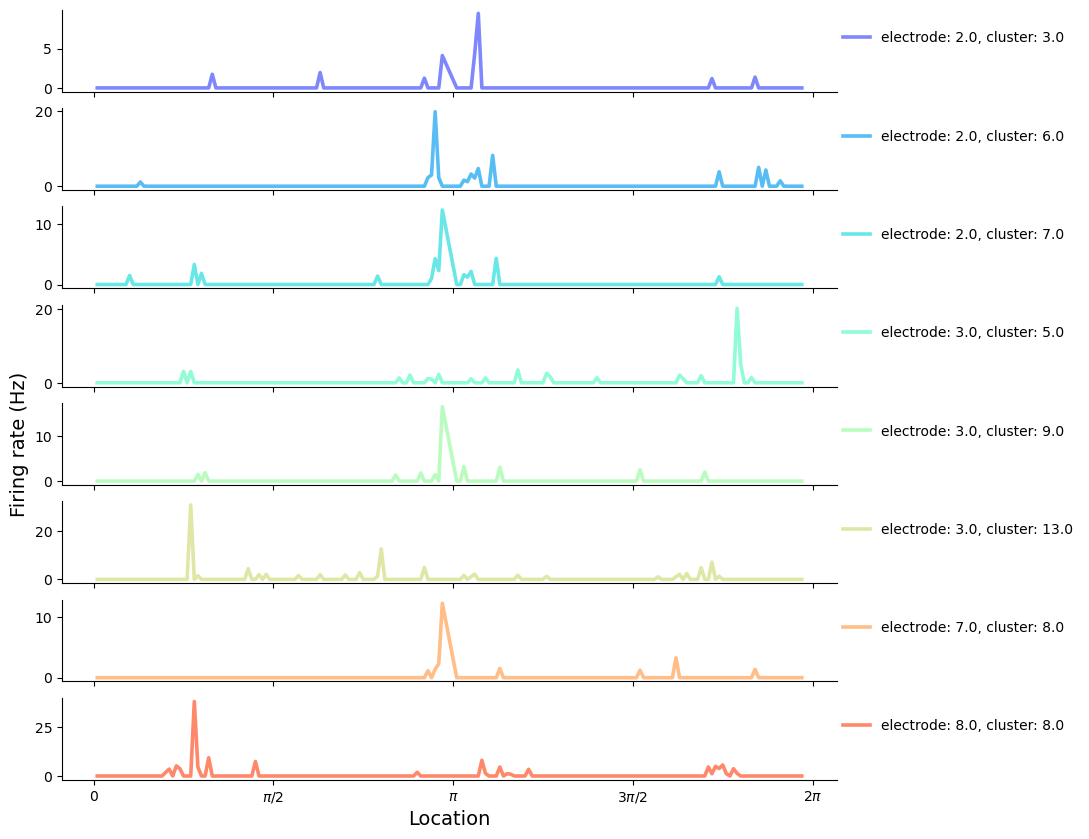

In [16]:
fig, ax = plt.subplots(ele_arr.shape[0], 1, sharex=True, figsize=(10,10))
color_list = sns.color_palette('rainbow', clu_arr.shape[0])

for i in range(ele_arr.shape[0]):
    print(ele_arr[i], clu_arr[i])
    fx, bins = get_firing_rate_hist(0, ele_arr[i], clu_arr[i], 90, True)
    #fx = gaussian_filter1d(fx, sigma=50*BIN_SIZE)
    ax[i].plot(bins, fx, lw=2.6, alpha=.7, label=f'electrode: {ele_arr[i]}, cluster: {clu_arr[i]}', color=color_list[i])
    # ax[i].stairs(BINS_X, fx, lw=2.6, alpha=.7, label=f'electrode: {ele_arr[i]}, cluster: {clu_arr[i]}', color=color_list[i]) # f'electrode: {ele_arr[i]}, cluster: {clu_arr[i]}' f'cluster# {clu}'
    ax[i].legend(frameon=False, loc=(1.,0.5))

ax[-1].set_xlabel('Location', fontsize=14)
ax[4].set_ylabel('Firing rate (Hz)', fontsize=14)

ax[-1].set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], labels=[r'0',r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$2\pi$'])

sns.despine()

2.0 3.0
2.0 6.0
2.0 7.0
3.0 5.0
3.0 9.0
3.0 13.0
7.0 8.0
8.0 8.0


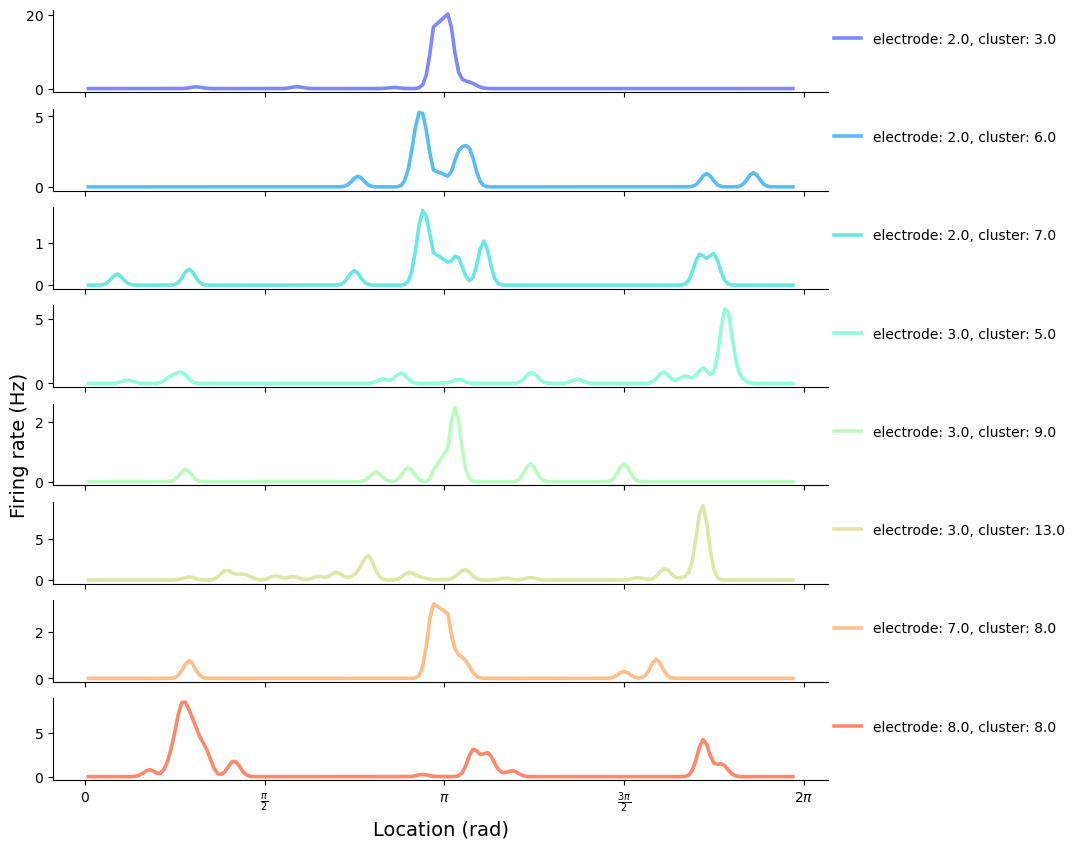

In [19]:
fig, ax = plt.subplots(ele_arr.shape[0], 1, sharex=True, figsize=(10,10))
color_list = sns.color_palette('rainbow', clu_arr.shape[0])

for i in range(ele_arr.shape[0]):
    print(ele_arr[i], clu_arr[i])
    fx, bins = get_firing_rate_hist(-200e-3, ele_arr[i], clu_arr[i], 90, True)
    fx = gaussian_filter1d(fx, sigma=50*BIN_SIZE)
    ax[i].plot(bins, fx, lw=2.6, alpha=.7, label=f'electrode: {ele_arr[i]}, cluster: {clu_arr[i]}', color=color_list[i]) # f'electrode: {ele_arr[i]}, cluster: {clu_arr[i]}' f'cluster# {clu}'
    ax[i].legend(frameon=False, loc=(1.,0.5))

ax[-1].set_xlabel('Location (rad)', fontsize=14)
ax[4].set_ylabel('Firing rate (Hz)', fontsize=14)
ax[-1].set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], labels=[r'0',r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'])

sns.despine()

# Write a function to fit the distributions
The function should:
1. Take a gaussian smoothed or raw distribution and bin array.
1. Call the function `get_optimal_basis_functions()` and find the optimal basis functions that fit the function.
1. Use the basis functions to reconstruct the distribution.
1. Return fitted function of a higher spatial resolution.

In [ ]:
# def fit_distribution(y_data, x_data, res):
#     '''
#     Inputs: y_data, x_data, res (resolution # points on the reconstructed function)
#     Outputs: y_fit, x_new (new long x_array)
#     '''

#     # get the optimal number of basis functions
#     op_df = get_optimal_basis_functions(y_data, x_data)
#     if op_df.shape[0] == 0:
#         raise Exception('Could not fit the data well. Try smoothning or increasing the steepness of template function')
#     else:
#         pass

#     # extract the best-fitting number of functions
#     op_df.sort_values(by=['cosine_sim'], ascending=False, inplace=True)
#     op_df.reset_index(inplace=True, drop=True)
#     optim_func = op_df.iloc[0,0]

#     # fit the distribution and get a higher spatial-resolution
#     alphas = np.logspace(-3, 7, 15)
#     X, theta = span_x_von_Mises(optim_func, y_data.shape[0])
#     fit = ridge_cv(X, y_data, alphas)
#     w = fit.coef_
#     X_res, theta = span_x_von_Mises(optim_func, res)
#     y_fit = X_res@w
#     x_new = np.linspace(0., 2*np.pi, res)

#     # translate the curve if there are negative values
#     if np.any(y_fit < 0):
#         y_fit = y_fit + abs(np.amin(y_fit))
#     else:
#         pass

#     return y_fit, x_new

In [ ]:
fx, bins = get_firing_rate_hist(-200e-3, ele_arr[1], clu_arr[1], 90, True)
#fx = gaussian_filter1d(fx, sigma=50*BIN_SIZE)
plt.plot(bins, fx, alpha=.7)
np.random.shuffle(fx)
plt.plot(bins, fx, alpha=.7)

#y_fit, x_new = fit_distribution(fx, bins, 3000)
#y_fit = y_fit/np.trapz(y_fit, x_new)
#plt.plot(x_new, y_fit)
# plt.plot(bins, fx)
# plt.plot(bins, fx2)

In [ ]:
# fit the occupancy probability
p_90, bins_p90 = get_occupany_hist(circularize_location(speed_df, 90, True))
p_90 = p_90/np.trapz(p_90, bins_p90)

p_90 = gaussian_filter1d(p_90, sigma=5*BIN_SIZE)

p_90_fit, x_new = fit_distribution(p_90, bins_p90, 3000)
p_90_fit = p_90_fit/np.trapz(p_90_fit, x_new)
plt.plot(x_new, p_90_fit, label='fit')
plt.plot(bins_p90, p_90, label='data')
plt.legend()

In [17]:
## get the MI!!!
# fit the occupancy probability
res = 3000
p_90, bins_p90 = get_occupany_hist(circularize_location(speed_df, 90, True))
p_90 = p_90/np.trapz(p_90, bins_p90)

p_90 = gaussian_filter1d(p_90, sigma=5*BIN_SIZE)

p_90_fit, x_new = fit_distribution(p_90, bins_p90, res)
p_90_fit = p_90_fit/np.trapz(p_90_fit, x_new)

t_delay_arr = np.linspace(-0.5, 0.5, 51)
# mi_df = pd.DataFrame(columns=['electrode', 'cluster', 't_delay', 'mi'])
# dummy = pd.DataFrame(columns=['electrode', 'cluster', 't_delay', 'mi'])

for i in range(clu_arr.shape[0]):
    mi_list = []
    print(i)
    for t in t_delay_arr:
        # get firing rate histogram
        fx, bins = get_firing_rate_hist(t, ele_arr[i], clu_arr[i], 90, True)

        # smoothen it!
        fx = gaussian_filter1d(fx, sigma=50*BIN_SIZE)

        # fit and increase resolution to 3000 points
        fx_fit, x_res = fit_distribution(fx, bins, res)

        # find mi
        mi = mi_rate(fx_fit, p_90_fit, x_res)
        mi_list.append(mi)
    
    print(mi_list)
    mi_list = np.array(mi_list)
    cells = np.ones(mi_list.shape[0])*clu_arr[i]
    ele = np.ones(mi_list.shape[0])*ele_arr[i]

    if i == 0:
        mi_df = pd.DataFrame(
            {
                'electrode': ele,
                'cluster': cells,
                't_delay': t_delay_arr,
                'mi': mi_list
            }
        )

    else:
        dummy = pd.DataFrame(
            {
                'electrode': ele,
                'cluster': cells,
                't_delay': t_delay_arr,
                'mi': mi_list 
            }
        )

        # append to mi_df
        mi_df = pd.concat([mi_df, dummy], axis=0, ignore_index=True)
    
    print(mi_df.shape)
    


mi_df



0
[0.12213518390487925, 0.11945740723707787, 0.11733074152685549, 0.11964899868433274, 0.16645769936041024, 0.20755152918517797, 0.16537399367525965, 0.16165926098997918, 0.16165926098997918, 0.9006905939594899, 0.9041616695673691, 0.9100760432223935, 0.7429530442868928, 0.7436832150530944, 0.7312405094194332, 0.7429386785305285, 0.6940020959351347, 0.21567160005109634, 0.22852269435804726, 0.22897053432199538, 0.22897053432199538, 0.16149397433808726, 0.16149397433808726, 0.16205938311115758, 0.15018460360029418, 0.1537599349447415, 0.15623247674732685, 0.15567222793675864, 0.1397839661835865, 0.13062574823333073, 0.14274852586297912, 0.1284856790701473, 0.12162965134785235, 0.11913954718591599, 0.10823587859233581, 0.0767755297314967, 0.09053178798224301, 0.08938467969615888, 0.07044362768595964, 0.15141066759011593, 0.15141066759011593, 0.1306006949347217, 0.15248967121210844, 0.10849167244273919, 0.1250206770115317, 0.07446013466088149, 0.11672374641601757, 0.11159081157499567, 0.0

,electrode,cluster,t_delay,mi
0,2.0,3.0,-0.50,0.122135
1,2.0,3.0,-0.48,0.119457
2,2.0,3.0,-0.46,0.117331
3,2.0,3.0,-0.44,0.119649
4,2.0,3.0,-0.42,0.166458
...,...,...,...,...
403,8.0,8.0,0.42,0.903820
404,8.0,8.0,0.44,0.802604
405,8.0,8.0,0.46,0.787470
406,8.0,8.0,0.48,0.668130


In [18]:
## save the mi file
save_df(mi_df, FIL_DATA_PATH, 'TEMP_mi_df.csv')

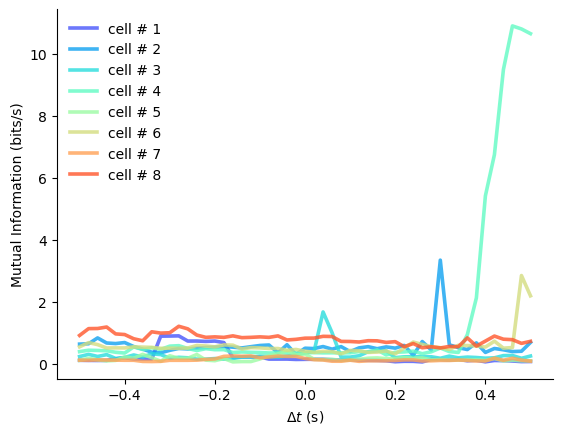

In [19]:
# plotting: everything on one figure
sns.set_palette('rainbow', 8)
fig, ax = plt.subplots()

for i,ele in enumerate(ele_arr):
    df = mi_df.loc[mi_df['electrode'] == ele].loc[mi_df['cluster'] == clu_arr[i]]
    ax.plot(df['t_delay'], df['mi'], alpha=.8, lw=2.6, label=f'cell # {i+1}')

ax.legend(frameon=False)
ax.set_xlabel(r'$\Delta t$ (s)')
ax.set_ylabel(r'Mutual Information (bits/s)')
sns.despine()

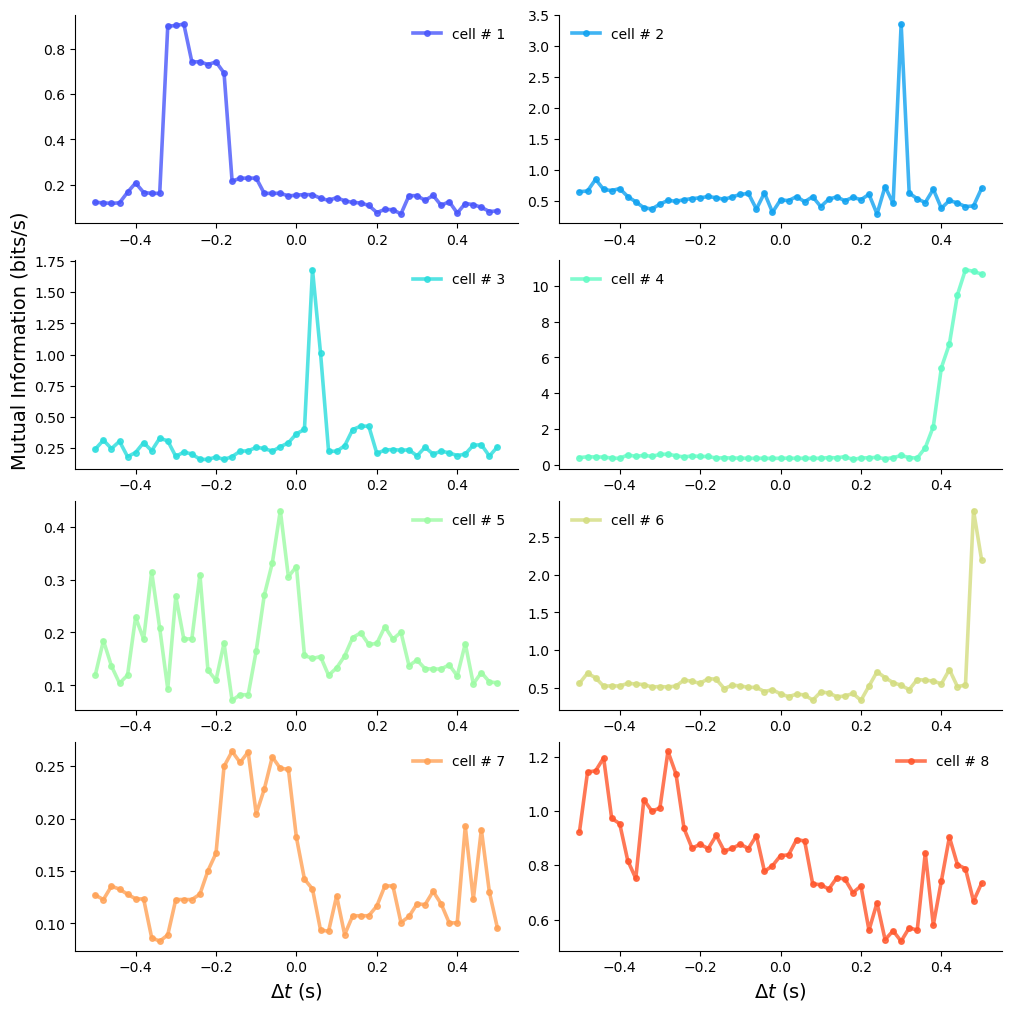

In [20]:
# plotting: one cell one figure
cell_num = np.arange(ele_arr.shape[0])
fig, axs = plt.subplots(4,2, constrained_layout=True, figsize=(10, 10))

for ax, c, e, color, c_num in zip(axs.flat, clu_arr, ele_arr, color_list, cell_num):
    df = mi_df.loc[mi_df['electrode'] == e].loc[mi_df['cluster'] == c]
    ax.plot(df['t_delay'], df['mi'], alpha=.8, lw=2.6, label=f'cell # {c_num+1}', color = color,  marker='o', ms=4)
    ax.legend(frameon=False)


# for i,ele in enumerate(ele_arr):
#     df = mi_df.loc[mi_df['electrode'] == ele].loc[mi_df['cluster'] == clu_arr[i]]
#     ax[i].plot(df['t_delay'], df['mi'], alpha=.8, lw=2.6, label=f'cell # {i+1}')
#     ax[i].legend(frameon=False)
axs[-1,0].set_xlabel(r'$\Delta t$ (s)', fontsize=14)
axs[-1,-1].set_xlabel(r'$\Delta t$ (s)', fontsize=14)
axs[1,0].set_ylabel(r'Mutual Information (bits/s)', fontsize=14, loc='bottom')
    
# ax[4].set_ylabel(r'Mutual Information (bits/s)')
# ax.reshape((4,2))
sns.despine()
plt.show()

In [ ]:
fx, bins = get_firing_rate_hist(0, ele_arr[0], clu_arr[0], 90, True)
fx = gaussian_filter1d(fx, sigma=5*BIN_SIZE)
df_op = get_optimal_basis_functions(fx, bins)
df_op.sort_values(by=['cosine_sim'], ascending=False, inplace=True)
#df_op.reset_index(inplace=True, drop=True)
df_op

# Bootstrap analysis
- Determine the baseline mutual information between location input and neuron firing.


In [101]:
def mi_rate2(lx, px, bin_loc):
    '''
    PILOT: Use instead of mi_rate()
    Uses direct matrix multiplication instead of using trapz.
    So far the two functions are giving slightly different values of mi
    Inputs: lx (firing rate distribution), px (p(x)), bin_loc (x bins)
    '''
    # remove the zeros in lambda(x) so that the log doesn't blow
    ## make a dummy dataframe
    dummy = pd.DataFrame(
        {
            'lx': lx,
            'px': px,
            'x' : bin_loc
        }
    )
    ## remove the rows with lx=0
    dummy = dummy.loc[dummy['lx'] > 0]
    # get back the numpy arrays
    lx = dummy['lx'].to_numpy()
    px = dummy['px'].to_numpy()
    x = dummy['x'].to_numpy()
    # find overall firing rate 
    l_overall = exp_value(dummy['lx'], dummy['px'], bin_loc) # np.trapz(lx*px, x)

    # mi_func = lx*px*np.log2(lx/l_overall)
    # I = np.trapz(mi_func, x)


    # # split up the sum into two parts
    # dx = np.diff(x)[0] zero locations are dropped!! this won't work!!
    # print(dx)
    l_log = lx*px*BIN_SIZE
    I = np.dot(l_log, lx/l_overall)

    return I

def bootstrap_mi(firing_rate_dist, location_dist, bins_x, num_iters):
    '''
    PILOT
    This function does bootstrap analysis to determine baseline mutual information.
    Inputs: 1. firing_rate_dis: firing rate distribution; output of get_firing_rate_hist()
    2. location_dist: distribution of occupancy p(x); output of get_occupancy_hist() 
    3. num_iters: number of times the MI is to be determines for randomized vector
    4. bins_x: array containing bins of locations
    '''

    # make a copy of the firing rate districution
    fr_copy = np.copy(firing_rate_dist)

    # define a rangom number generator
    rng = default_rng(123456)

    # define an empty list to store MI
    I_list = []

    # find actual MI
    I_actual = mi_rate2(firing_rate_dist, location_dist, bins_x)
    # print(I_actual)


    # start a for loop
    for i in range(num_iters):
        # randomize the firing rate distribution
        sh_arr = rng.permuted(fr_copy)
        I = mi_rate(sh_arr, location_dist, bins_x)
        I_list.append(I)
        #plt.plot(bins_x, fr_copy, alpha=0.2)
    
    I_list = np.array(I_list)
    n_I, bins_I = np.histogram(I_list, bins=200)

    # plt.plot(bins_I[:-1], n_I)
    # plt.axvline(x=I_actual, ymin=0, ymax=np.amax(n_I))
    # plt.show()

    return n_I, bins_I, I_actual

def get_firing_rate_hist2(delay_time, ele, cell, prc, prc_flag):
    '''
    PILOT
    Returns discrete lambda(x) distribution in Hz for a given cell and delay-time
    Inputs:
    1. delay_time (float): time in seconds by which the spiketrain needs to be delayed
    2. ele (int): electrode #
    3. cell (int): cell #
    4. prc (int): velocity threshold percentile 
    5. prc_flag: bool. True for percentile threshold, False for float threshold

    Outputs:
    lambda_loc (firing rate distribution), n_x (p(x)), bins: firing rate and bins to plot histogram
    '''
    # set the correct path
    ch_dir(FIL_DATA_PATH)

    # read the xyt_df
    xyt_df = pd.read_csv('gor01_2006-6-7_11-26-53_loc_time.csv')

    # get delayed spike train for circularized locations
    df = delay_spiketrain_speed(delay_time, ele, cell)
    shift_df = filter_spiketimes_by_speed(df, prc, prc_flag)

    # find the PDF histogram of spike locations
    s_x, bins_loc = np.histogram(shift_df['x_mean'], bins=BINS_X)

    # find the speed dataframe
    speed_df = get_speed_df(xyt_df)

    # compute the number of times the rat visited the location
    circ_loc_df = circularize_location(speed_df, prc, prc_flag)

    # get the occypancy histogram
    n_x, bins_x = get_occupany_hist(circ_loc_df)
    # print(n_x)

    # remove points where nx = 0
    ## create a dummy dataframe

    dummy = pd.DataFrame(
        {
            'n_loc': s_x,
            'n_x': n_x,
            'bins_x': bins_x
        }
    )

    ## filter out places where n_x = 0
    dummy = dummy.loc[dummy['n_x'] > 0]

    ## get numpy arrays back
    s_x = dummy['n_loc'].to_numpy()
    n_x = dummy['n_x'].to_numpy()
    bins_x = dummy['bins_x'].to_numpy()
    n_x_norm = n_x/np.trapz(n_x, bins_x)

    # compute the firing rate
    # print(np.amin(n_x))
    lambda_loc = (s_x/n_x)*LOC_SAMPLING_FREQUENCY
    lambda_loc = np.nan_to_num(lambda_loc, nan=0)
    

    return lambda_loc, n_x_norm, bins_x

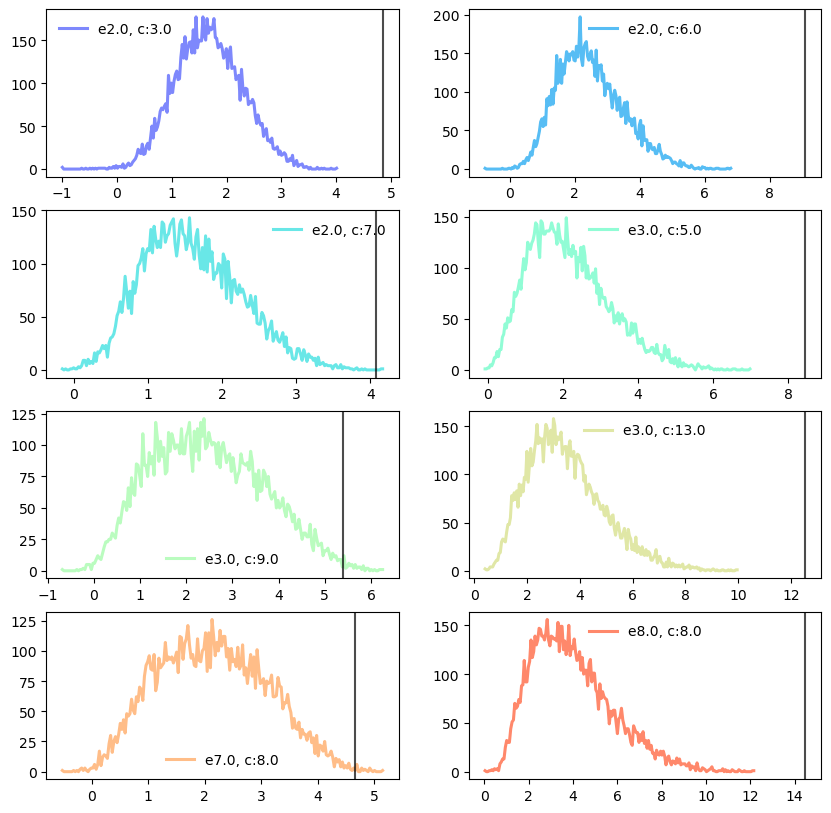

In [104]:
color_list = sns.color_palette('rainbow', 8)
# pilot run for bootstrap analysis
# get occupancy
# p_90, bins_90 = get_occupany_hist(circularize_location(speed_df, 90, True))
# # extract pdf from the pmf
# p_90 = p_90/np.trapz(p_90, bins_90)

# # fit the distribution to function
# p_90_fit, bins_90_fit = fit_distribution(p_90, bins_90, 3000)

# print(ele_arr.shape, clu_arr.shape)

# define a subplotgrid
fig, axs = plt.subplots(4,2, figsize=(10,10))

# initiate for loop
for ax, e, c, col in zip(axs.flat, ele_arr, clu_arr, color_list):
    # get firing rate
    fx, p_90, fx_bins = get_firing_rate_hist2(0,e,c,90,True)
    # fx = gaussian_filter1d(fx, sigma=40*BIN_SIZE)
    # fx_fit, fx_fit_bins = fit_distribution(fx, fx_bins, 3000)
    n_I, bins_I, i_a = bootstrap_mi(fx, p_90, fx_bins,10000)
    ax.plot(bins_I[:-1], n_I, label=f'e{e}, c:{c}', lw=2.2, alpha=.7, c=col)
    ax.axvline(x=i_a, ymin=0, ymax=np.amax(n_I), c='k', alpha=.7)
    ax.legend(frameon=False)



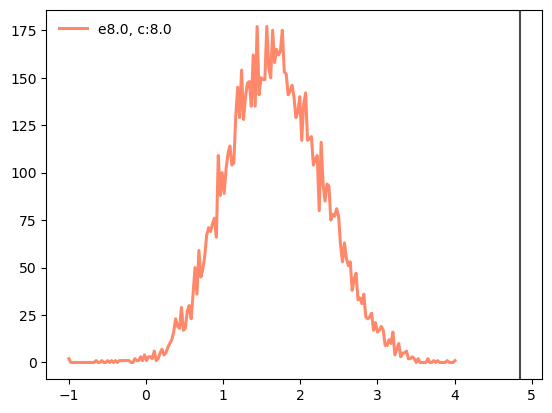

In [103]:
f26, p_26, f26_bins = get_firing_rate_hist2(0,2,3,90,True)
n_I, bins_I, i_a = bootstrap_mi(f26, p_26, f26_bins,10000)
plt.plot(bins_I[:-1], n_I, label=f'e{e}, c:{c}', lw=2.2, alpha=.7, c=col)
plt.axvline(x=i_a, ymin=0, ymax=np.amax(n_I), c='k', alpha=.7)
plt.legend(frameon=False)

In [92]:
f26, p_26, f26_bins = get_firing_rate_hist2(0,8,8,90,True)
print(mi_rate2(f26, p_26, f26_bins))

14.482075652351266


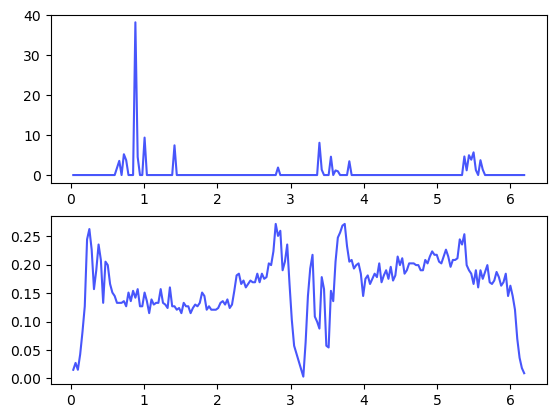

In [93]:
fig, ax = plt.subplots(2,1)
ax[0].plot(f26_bins, f26)
ax[1].plot(f26_bins,p_26)

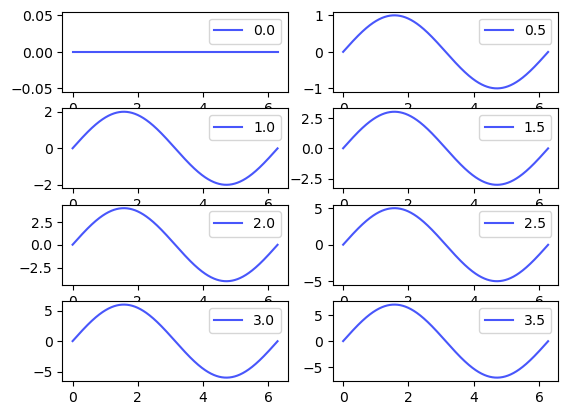

In [45]:
t_dummy = np.arange(0., 2*np.pi, 0.01)
y_dummy = np.sin(t_dummy)
fig, axs = plt.subplots(4,2)

for ax, i, j in zip(axs.flat, np.arange(8), np.arange(8)/2):
    ax.plot(t_dummy, i*y_dummy, label=f'{j}')
    ax.legend()

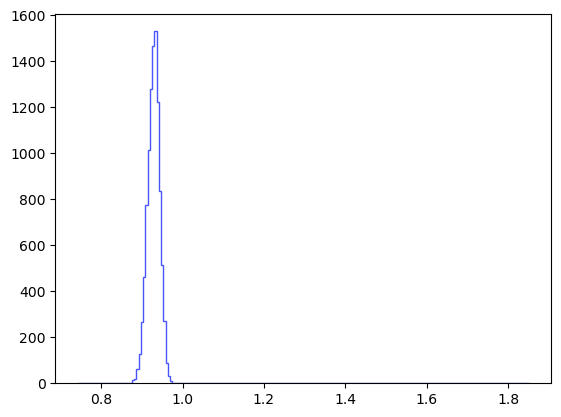

In [27]:
plt.stairs(n, bins)

In [ ]:
fx, bins = get_firing_rate_hist(0, ele_arr[0], clu_arr[0], 90, True)
fx = gaussian_filter1d(fx, sigma=50*BIN_SIZE)
fx_fit, new_bins = fit_distribution(fx, bins, 3000)
fx_fit_copy = fx_fit
plt.plot(bins, fx, alpha=.7)
plt.plot(new_bins, fx_fit, alpha=.7)
shuffle(fx_fit)
plt.plot(new_bins, fx_fit, alpha=.7)
plt.plot(new_bins, fx_fit_copy, alpha=.7, c='r')

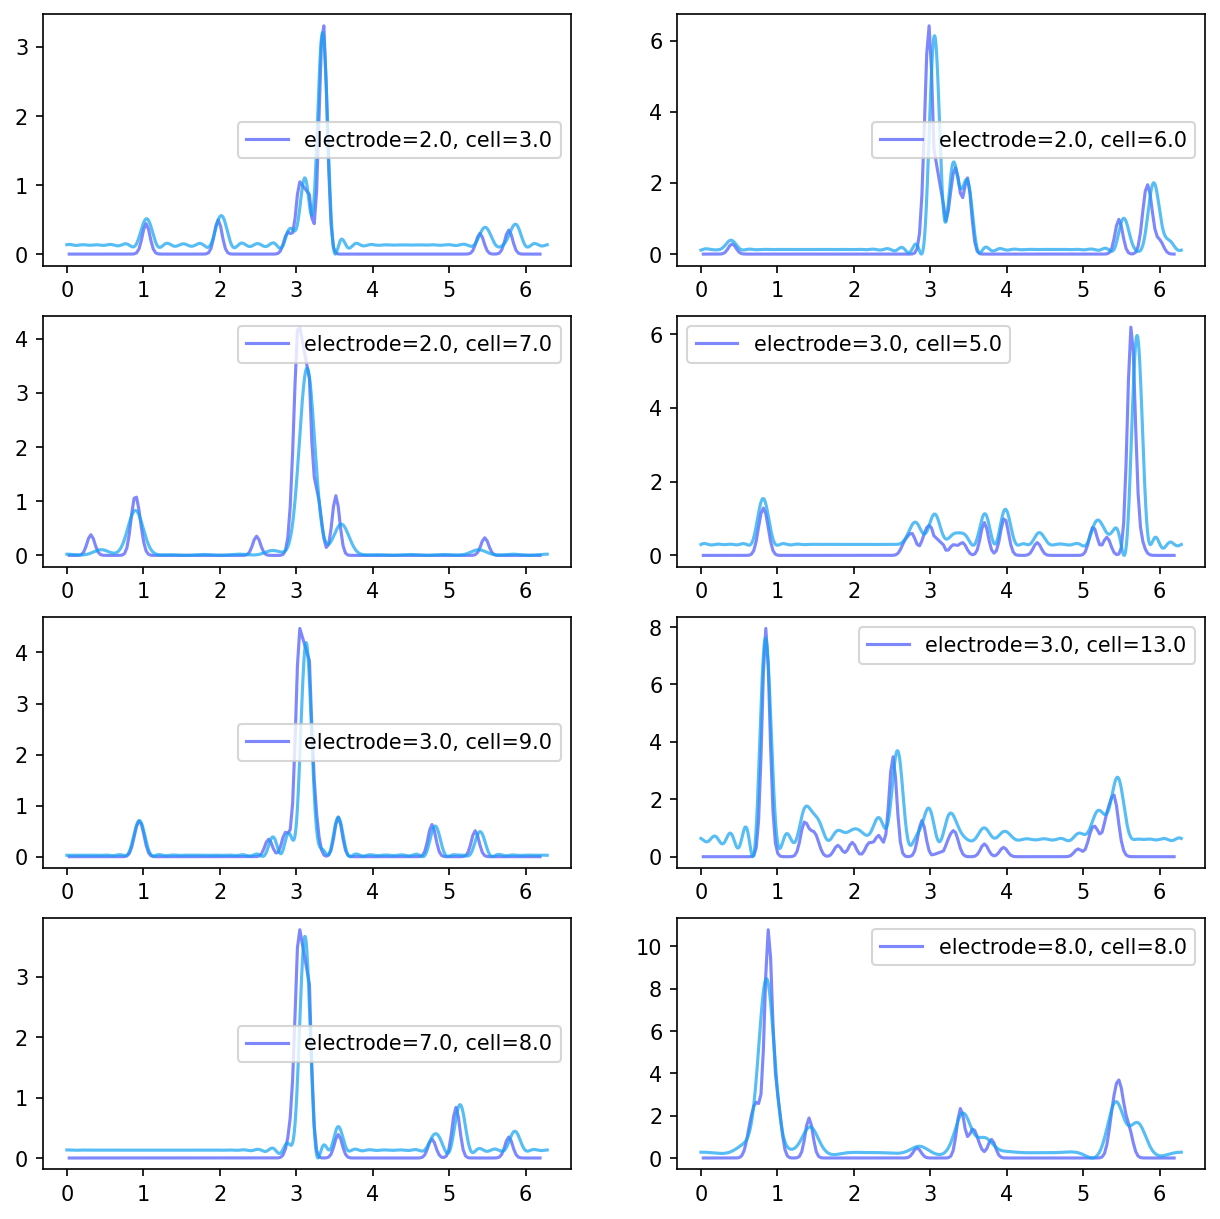

In [29]:
fig, axs = plt.subplots(4,2, dpi=150, figsize=(10,10))

for ax, e, c in zip(axs.flat, ele_arr, clu_arr):
    fx, bins = get_firing_rate_hist(0, e, c, 90, True)
    fx = gaussian_filter1d(fx, sigma=50*BIN_SIZE)
    fx_fit, new_bins = fit_distribution(fx, bins, 3000)

    ax.plot(bins, fx, alpha=.7, label=f'electrode={e}, cell={c}')
    ax.plot(new_bins, fx_fit, alpha=.7)
    ax.legend()
